In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk1' / 'ecephys_data'

cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')

In [3]:
session_id = 715093703

In [4]:
session = cache.get_session_data(session_id)

In [5]:
session.structurewise_unit_counts

CA1      145
LP       139
grey     117
LGd       82
PO        76
VISrl     76
VISp      60
VISpm     50
VISl      42
VISam     30
APN       26
DG        26
CA3       14
PoT        1
Name: ecephys_structure_acronym, dtype: int64

In [6]:
session.probes

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
810755797,probeA,See electrode locations,29999.954846,1249.998119,True
810755799,probeB,See electrode locations,29999.906318,1249.996097,True
810755801,probeC,See electrode locations,29999.985470,1249.999395,True
810755803,probeD,See electrode locations,29999.908100,1249.996171,True
810755805,probeE,See electrode locations,29999.985679,1249.999403,True
810755807,probeF,See electrode locations,30000.028033,1250.001168,True


In [7]:
VISpm_probe_id = 810755799
VISp_probe_id = 810755801

In [8]:
# lfp = session.get_lfp(VISpm_probe_id)
# lfp

In [9]:
lfp = session.get_lfp(VISp_probe_id)
lfp

<xarray.DataArray 'LFP' (time: 11070604, channel: 95)>
array([[-3.7049998e-05, -4.1535000e-05, -5.5184999e-05, ...,
         2.1450001e-06, -3.1200000e-06, -1.5600000e-06],
       [ 1.6185000e-05, -2.1840000e-05, -4.1924999e-05, ...,
        -1.3650000e-06,  1.3650000e-06, -3.9000001e-06],
       [ 3.0224999e-05,  8.1899998e-06, -2.0084999e-05, ...,
         7.2150001e-06, -9.9449999e-06, -5.6549998e-06],
       ...,
       [ 3.0498000e-04,  3.2350500e-04,  2.9328000e-04, ...,
         5.8500000e-06,  2.4569999e-05, -4.0560000e-05],
       [ 2.1235499e-04,  2.6305500e-04,  2.5740001e-04, ...,
         5.0700000e-06,  2.6129999e-05, -4.1730000e-05],
       [ 1.6165500e-04,  1.8973500e-04,  1.7218500e-04, ...,
         7.7999999e-07,  8.5800002e-06, -1.6380000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 26.88 26.89 26.89 ... 9.578e+03 9.578e+03 9.578e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

### Relating channel unique indices and local probe indices

In [10]:
lfp_channel_indices = cache.get_channels().loc[lfp.channel.values].local_index.values

In [11]:
lfp_channel_indices

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154,
       158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206,
       210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254, 258,
       262, 266, 270, 274, 278, 282, 286, 290, 294, 298, 302, 306, 310,
       314, 318, 322, 326, 330, 334, 338, 342, 346, 350, 354, 358, 362,
       366, 370, 374, 378])

In [12]:
temp_channels_df = cache.get_channels()
lfp_channel_dict = {temp_channels_df.loc[k].local_index.item():k  for k in lfp.channel.values}

In [13]:
print(len(lfp_channel_dict))
print(lfp_channel_dict)

95
{2: 850261198, 6: 850261206, 10: 850261214, 14: 850261222, 18: 850261230, 22: 850261238, 26: 850261246, 30: 850261254, 34: 850261262, 38: 850261270, 42: 850261278, 46: 850261286, 50: 850261294, 54: 850261302, 58: 850261310, 62: 850261318, 66: 850261326, 70: 850261334, 74: 850261342, 78: 850261350, 82: 850261358, 86: 850261366, 90: 850261374, 94: 850261382, 98: 850261390, 102: 850261398, 106: 850261406, 110: 850261414, 114: 850261422, 118: 850261430, 122: 850261438, 126: 850261446, 130: 850261454, 134: 850261462, 138: 850261470, 142: 850261478, 146: 850261486, 150: 850261494, 154: 850261502, 158: 850261510, 162: 850261518, 166: 850261526, 170: 850261534, 174: 850261542, 178: 850261550, 182: 850261558, 186: 850261566, 190: 850261574, 194: 850261582, 198: 850261590, 202: 850261598, 206: 850261606, 210: 850261614, 214: 850261622, 218: 850261630, 222: 850261638, 226: 850261646, 230: 850261654, 234: 850261662, 238: 850261670, 242: 850261678, 246: 850261686, 250: 850261694, 254: 850261702,

### Plotting LFP with annotated regions

In [14]:
structure_acronyms, intervals = session.channel_structure_intervals(lfp["channel"])
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

print('FirstChannel--Structure--LastChannel')
for aa, bb, i in zip(intervals[:-1], intervals[1:], range(len(intervals))): print(f'{aa}--{structure_acronyms[i]}--{bb}')

FirstChannel--Structure--LastChannel
0--PO--4
4--PoT--5
5--LP--26
26--DG--42
42--CA1--62
62--VISp--85
85--nan--95


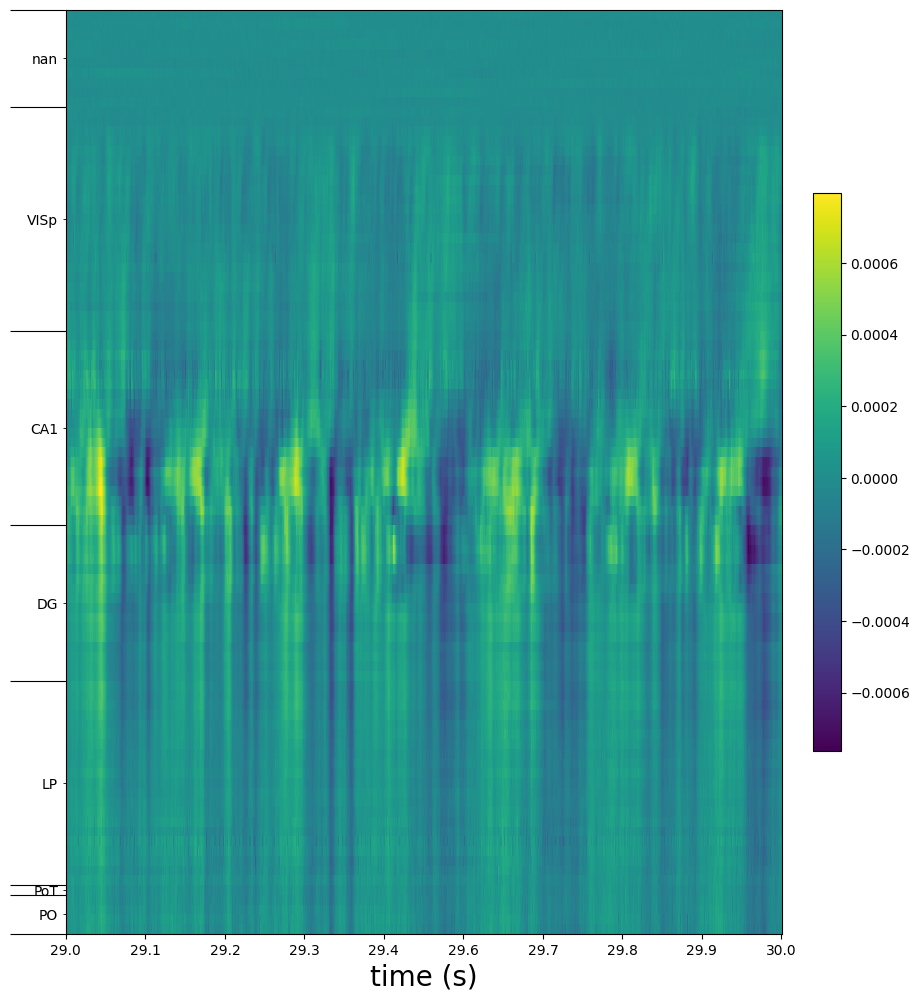

In [15]:
lfp_slice = lfp.sel(time=slice(29,30))

fig, ax = plt.subplots(figsize=(10,12))
pcolormesh_obj = ax.pcolormesh(lfp_slice.T)

# Plotting structure names + intervals on y-axis
ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
ax.tick_params("y", which="major", labelleft=False, length=40)

# Plotting time instead of samples on x-axis
num_time_labels = 10
time_label_indices = np.around(np.linspace(1, len(lfp_slice["time"]), num_time_labels)).astype(int) - 1
time_labels = np.around(lfp_slice["time"][time_label_indices].data, decimals=1)
ax.set_xticks(time_label_indices + 0.5)
ax.set_xticklabels(time_labels)
ax.set_xlabel("time (s)", fontsize=20)

fig.colorbar(pcolormesh_obj, fraction=0.036, pad=0.04)

plt.show()

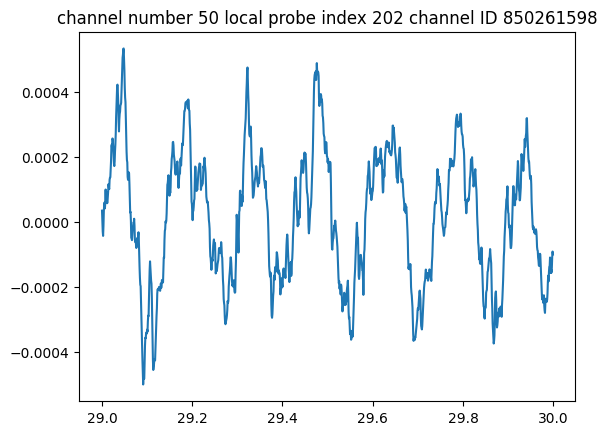

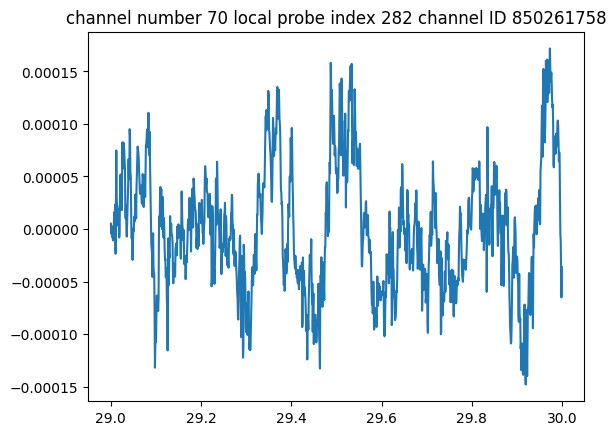

In [16]:
lfp_slice = lfp.sel(time=slice(29,30))

channel_num = 50 # CA1
channel_id = lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]] # to get the channel ID of 50th LFP local index, not of lFP local index = 50
plt.title(f"channel number {channel_num} local probe index {list(lfp_channel_dict.keys())[channel_num]} channel ID {channel_id}")
plt.plot(lfp_slice.time, lfp_slice.sel(channel=channel_id))
plt.show()

channel_num = 70 # VISp
channel_id = lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]]
plt.title(f"channel number {channel_num} local probe index {list(lfp_channel_dict.keys())[channel_num]} channel ID {channel_id}")
plt.plot(lfp_slice.time, lfp_slice.sel(channel=channel_id))
plt.show()

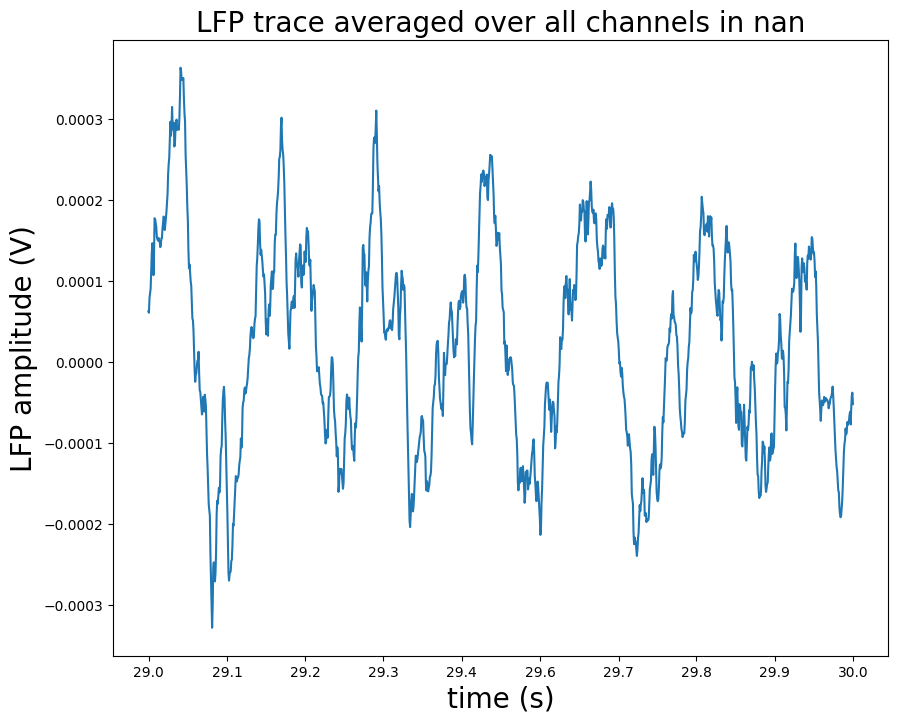

In [17]:
str_num = 4 # number of the structure from above (e.g. CA1 = 4th)

lfp_slice = lfp.sel(time=slice(29,30))

structure_traces = lfp_slice[:,intervals[str_num]:intervals[str_num+1]] # selecting all the timepoints in lfp_slice and channels within the range of i-th structure

mean_structure_trace = structure_traces.data.mean(axis=1)

plt.figure(figsize=(10,8))
plt.plot(mean_structure_trace)

# Plotting time instead of samples on x-axis
num_time_labels = 10
time_label_indices = np.around(np.linspace(1, len(lfp_slice["time"]), num_time_labels)).astype(int) - 1
time_labels = np.around(lfp_slice["time"][time_label_indices].data, decimals=1)
plt.gca().set_xticks(time_label_indices + 0.5)
plt.gca().set_xticklabels(time_labels)
plt.gca().set_xlabel("time (s)", fontsize=20)
plt.gca().set_ylabel("LFP amplitude (V)", fontsize=20)

plt.title(f'LFP trace averaged over all channels in {structure_acronyms[i]}', fontsize=20)

plt.show()

### Computing Current Source Density and locating layer 5 in primary visual cortex

In [18]:
VISp_channels_vertical_positions = session.channels[(session.channels.probe_id==VISp_probe_id) & (session.channels.ecephys_structure_acronym=='VISp')].probe_vertical_position
print(f'VISp veritcal extent: {VISp_channels_vertical_positions.min()}um - {VISp_channels_vertical_positions.max()}um')

VISp veritcal extent: 2500um - 3420um


/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal

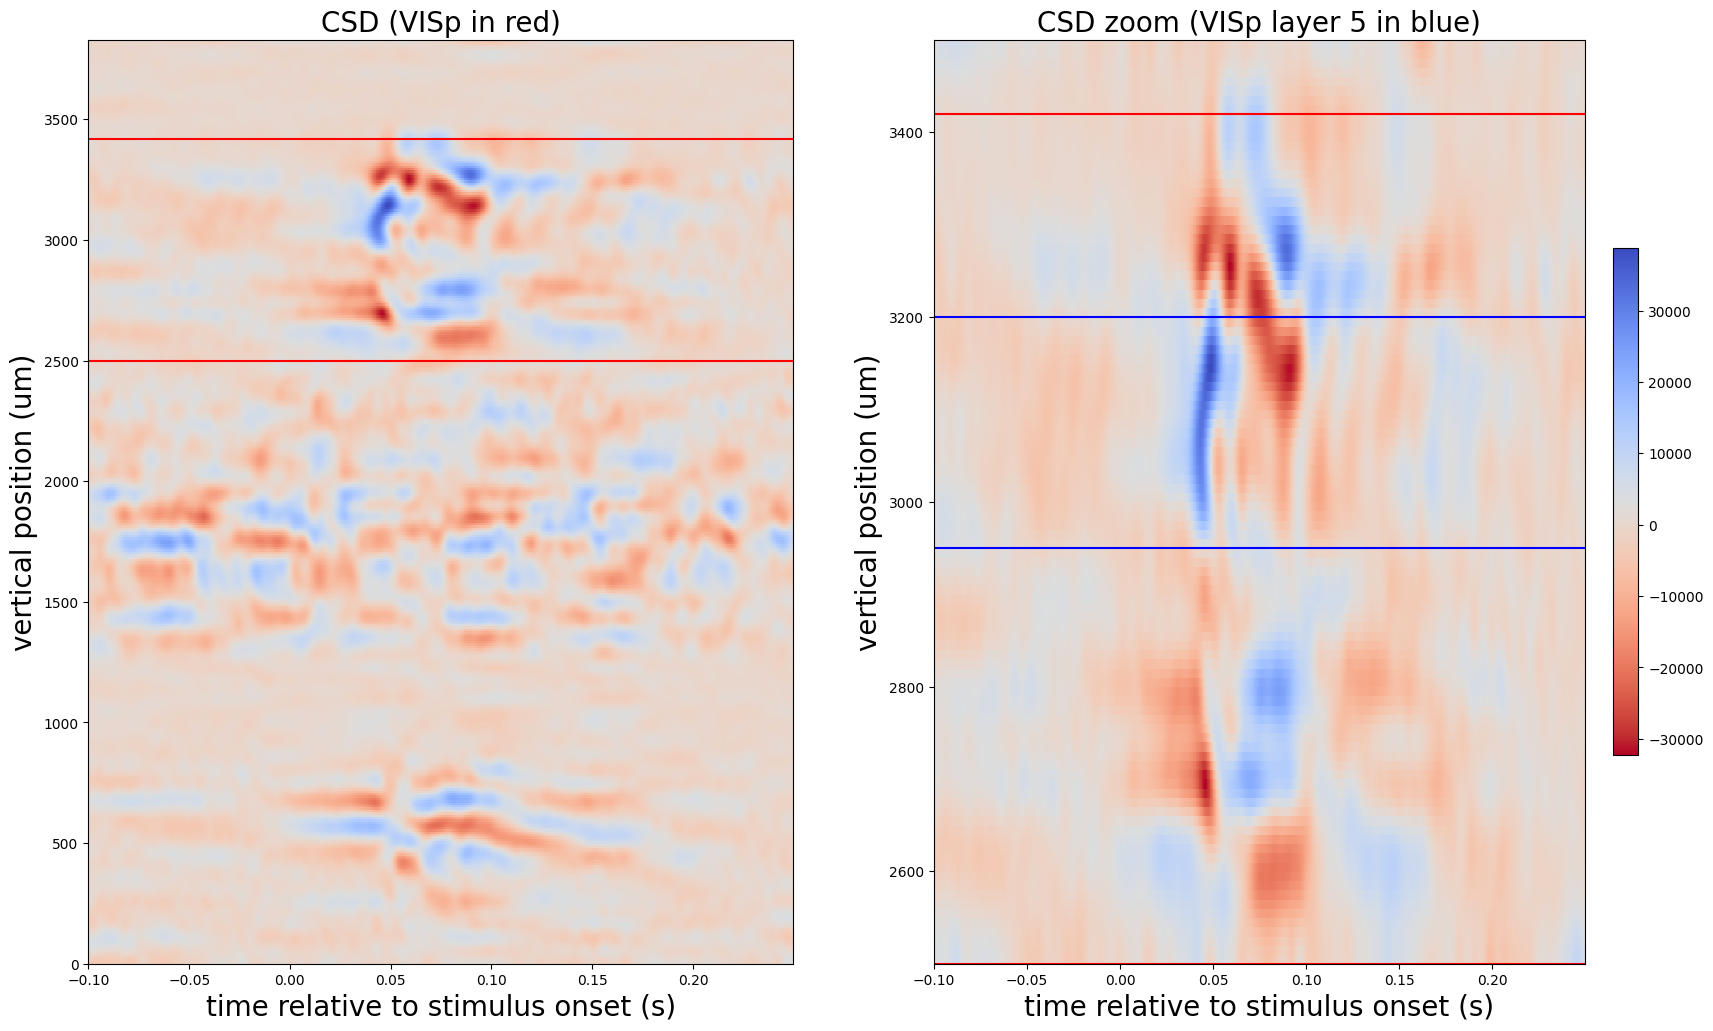

In [19]:
from scipy.ndimage.filters import gaussian_filter

csd = session.get_current_source_density(VISp_probe_id)

filtered_csd = gaussian_filter(csd.data, sigma=4)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 12))
pcolor_obj = ax[0].pcolor(csd["time"], csd["vertical_position"], filtered_csd, cmap='coolwarm_r')

ax[0].set_xlabel("time relative to stimulus onset (s)", fontsize=20)
ax[0].set_ylabel("vertical position (um)", fontsize=20)

ax[0].axhline(y=2500, color='r', linestyle='-')
ax[0].axhline(y=3420, color='r', linestyle='-')
ax[0].set_title('CSD (VISp in red)', fontsize=20)



csd_slice = csd.sel(virtual_channel_index=slice(250,350))
filtered_csd = gaussian_filter(csd_slice.data, sigma=4)
ax[1].pcolor(csd_slice["time"], csd_slice["vertical_position"], filtered_csd, cmap='coolwarm_r')
ax[1].set_xlabel("time relative to stimulus onset (s)", fontsize=20)
ax[1].set_ylabel("vertical position (um)", fontsize=20)
ax[1].set_title('CSD zoom (VISp layer 5 in blue)', fontsize=20)

ax[1].axhline(y=2500, color='r', linestyle='-')
ax[1].axhline(y=3420, color='r', linestyle='-')

ax[1].axhline(y=2950, color='b', linestyle='-')
ax[1].axhline(y=3200, color='b', linestyle='-')

fig.colorbar(pcolor_obj, fraction=0.036, pad=0.04)

plt.show()

### Looking at channels in VISp layer 5

In [20]:
chosen_layer5 = [2950,3200]

In [21]:
channel_df = cache.get_channels()
channel_df = channel_df[channel_df['ecephys_probe_id']==VISp_probe_id]
print(len(channel_df))
channel_df.head()

372


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
850261194,810755801,0,43,20,7648.0,3645.0,7567.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261196,810755801,1,11,20,7651.0,3636.0,7566.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261198,810755801,2,59,40,7654.0,3627.0,7566.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261200,810755801,3,27,40,7657.0,3618.0,7565.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,3
850261202,810755801,4,43,60,7660.0,3610.0,7564.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,2


These channels are within chosen layer 5 in terms of verical distance, but not all of them are associated with LFP recordings:

In [22]:
layer5_channels_df = channel_df[(channel_df['probe_vertical_position']>=chosen_layer5[0]) & (channel_df['probe_vertical_position']<chosen_layer5[1])]
print(len(layer5_channels_df))
layer5_channels_df

23


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
850261782,810755801,294,59,2960,8674.0,1038.0,8160.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261784,810755801,295,27,2960,8677.0,1026.0,8158.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,1
850261786,810755801,296,43,2980,8680.0,1014.0,8157.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,2
850261788,810755801,297,11,2980,8682.0,1003.0,8155.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,2
850261790,810755801,298,59,3000,8685.0,991.0,8154.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261792,810755801,299,27,3000,8688.0,979.0,8153.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261794,810755801,300,43,3020,8690.0,968.0,8151.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261796,810755801,301,11,3020,8693.0,956.0,8150.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,1
850261798,810755801,302,59,3040,8696.0,944.0,8149.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0


Checking which channels pulled from general channel list of this probe AND in vertical range established from CSD analysis (corresponding to layer 5), are available in full LFP trace time series data:

In [23]:
print('Channel ID -','Local Probe Index -','Channel Number')
for ch in lfp.channel.data:
    if len(layer5_channels_df[layer5_channels_df.index==ch])!=0:
        local_index = layer5_channels_df[layer5_channels_df.index==ch]['local_index'].item()
        channel_num = list(lfp_channel_dict.keys()).index(local_index)
        print(ch, local_index, channel_num)

Channel ID - Local Probe Index - Channel Number
850261782 294 73
850261790 298 74
850261798 302 75
850261806 306 76
850261814 310 77
850261822 314 78


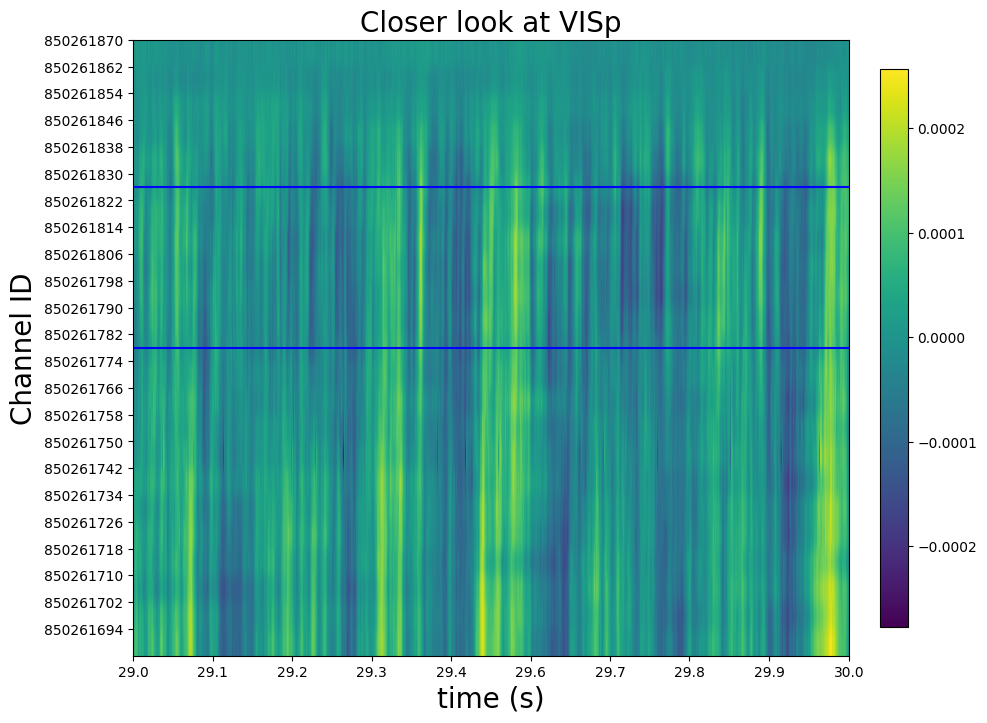

In [24]:
channel_ids = session.channels[(session.channels.probe_id == VISp_probe_id) & \
                 (session.channels.ecephys_structure_acronym.isin(['VISp']))].index.values

lfp_slice2 = lfp_slice.sel(channel=slice(np.min(channel_ids), np.max(channel_ids)))

fig,ax = plt.subplots(figsize=(10,8))
im = plt.imshow(lfp_slice2.T,aspect='auto',origin='lower')
# im = ax.pcolormesh(lfp_slice2.T)

fig.colorbar(im, fraction=0.036, pad=0.04)

# Plotting time instead of samples on x-axis
num_time_labels = 10
time_label_indices = np.around(np.linspace(1, len(lfp_slice2["time"]), num_time_labels)).astype(int) - 1
time_labels = np.around(lfp_slice2["time"][time_label_indices].data, decimals=1)
ax.set_xticks(time_label_indices + 0.5)
ax.set_xticklabels(time_labels)
ax.set_xlabel("time (s)", fontsize=20)

# Plotting channel IDs on y-axis
num_y_labels = len(lfp_slice2['channel'])
y_label_indices = np.around(np.linspace(1, len(lfp_slice2["channel"]), num_y_labels)).astype(int) - 1
ax.set_yticks(y_label_indices + 0.5)
ax.set_yticklabels(lfp_slice2['channel'].data)
ax.set_ylabel('Channel ID', fontsize=20)

# plotting layer 5
line1 = list(lfp_slice2['channel'].data).index(850261782) # to get the index of bordering channels
line2 = list(lfp_slice2['channel'].data).index(850261822)+1
ax.axhline(y=line1, color='b', linestyle='-')
ax.axhline(y=line2, color='b', linestyle='-')

ax.set_title('Closer look at VISp', fontsize=20)

plt.show()

### Aligning LFP to stimulus presentations

In [25]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,13.470683,73.537433,60.066750,spontaneous,null
1,73.537433,985.532551,911.995118,gabors,0.0
2,985.532551,1274.523973,288.991422,spontaneous,null
3,1274.523973,1573.023407,298.499434,flashes,1.0
4,1573.023407,1574.774823,1.751416,spontaneous,null
5,1574.774823,2174.275707,599.500885,drifting_gratings,2.0
6,2174.275707,2205.301633,31.025925,spontaneous,null
7,2205.301633,2805.836653,600.535020,natural_movie_three,3.0
8,2805.836653,2835.861733,30.025080,spontaneous,null
9,2835.861733,3136.112583,300.250850,natural_movie_one,4.0


In [26]:
stim_flashes = session.get_stimulus_table(['flashes'])
# equally stim_flashes = session.stimulus_presentations[session.stimulus_presentations.stimulus_name=='flashes']
stim_flashes

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1274.523973,1.0,flashes,1274.774189,0.250216,244
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1276.525623,1.0,flashes,1276.775842,0.250219,244
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1278.527343,1.0,flashes,1278.777552,0.250209,245
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1280.529013,1.0,flashes,1280.779222,0.250209,244
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1282.530723,1.0,flashes,1282.780924,0.250201,245
...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1564.766513,1.0,flashes,1565.016712,0.250199,245
3793,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1566.768143,1.0,flashes,1567.018352,0.250209,244
3794,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1568.769833,1.0,flashes,1569.020042,0.250209,244


In [27]:
stim_flashes['stimulus_condition_id'].unique()

array([244, 245])

In [28]:
presentation_times = stim_flashes.start_time.values
presentation_ids = stim_flashes.index.values

In [29]:
trial_window = np.arange(-0.5, 0.5, 1/500) # np.arange(start, stop, step)
# Trial window array (including 0.5s before and 0.5s after stimulus) is added to each timepoint linked to flash stimulus presentation
# Then all of these stim-presentation-related trial windows are concatenated into a single array
time_selection = np.concatenate([trial_window + t for t in presentation_times])

__Important to note that 1/500 increment here corresponds to downsampling to 500Hz__

In [30]:
# This repeatedly assigns basic trial window values (-0.5s:0.5s) to every stimulus presentation id, under the column label of 'time_from_presentation_onset'
inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                  names=('presentation_id', 'time_from_presentation_onset'))

In [31]:
# Selecting LFP data at trial window constrained flash presentation times by the nearest value available
# Saving this into a newly created 'aligned_lfp' inside of xarray dataset
dataset = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
# Assigning new variabes ('presentation_id' and 'time_from_presentation_onset' from inds) to the xarray dataset
# Removing time variable
# Now, for each presentation_id, there is a corresponding time_from_presentation_onset-long array of LFP data for all the channels
dataset = dataset.assign(time=inds).unstack('time')
aligned_lfp = dataset['aligned_lfp']

In [32]:
aligned_lfp

<xarray.DataArray 'aligned_lfp' (channel: 95, presentation_id: 150, time_from_presentation_onset: 500)>
array([[[ 1.13490001e-04,  5.46000010e-05,  9.02850006e-05, ...,
          9.57449956e-05,  8.79450017e-05,  1.71600004e-05],
        [ 8.96999973e-06,  4.07549996e-05,  8.38499982e-05, ...,
         -1.34550006e-04, -1.63410004e-04, -1.37084993e-04],
        [-2.78850002e-05, -3.21750013e-05, -2.49599998e-05, ...,
         -4.87500001e-05,  1.85249992e-05,  1.87200003e-05],
        ...,
        [ 8.18999979e-06,  3.90000014e-06,  4.54350011e-05, ...,
         -1.18559998e-04, -1.00229998e-04, -6.96150018e-05],
        [ 4.56300004e-05, -3.70499993e-06,  7.29300009e-05, ...,
          2.14499996e-05,  5.79150001e-05,  2.06700006e-05],
        [-1.00425001e-04,  1.11150002e-05,  1.13490001e-04, ...,
         -6.23999995e-06,  6.39599966e-05,  2.20349993e-05]],

       [[ 1.03350001e-04,  4.66050005e-05,  6.98099975e-05, ...,
          5.71349992e-05,  6.33750024e-05,  9.94499987e-06],
        [ 1.03350003e-05,  5.65500013e-05,  1.24995000e-04, ...,
         -1.36695002e-04, -1.21874997e-04, -1.04519997e-04],
        [-3.89999987e-05, -4.93349980e-05, -2.92499999e-06, ...,
         -1.71600004e-05,  3.17849990e-05,  3.04200003e-05],
        ...,
        [ 3.27599992e-05,  1.46249995e-05,  5.88900002e-05, ...,
         -9.92549976e-05, -9.75000003e-05, -2.92499990e-05],
        [ 2.82750007e-05, -1.73549997e-05,  2.65199997e-05, ...,
          3.72450013e-05,  5.30399993e-05,  2.59349999e-05],
        [-1.07834996e-04, -4.60199990e-05,  7.03949991e-05, ...,
         -4.48499986e-06,  5.98650004e-05,  1.20899995e-05]],

       [[ 9.30149981e-05,  5.22599985e-05,  5.36250009e-05, ...,
          7.17599978e-05,  6.70800000e-05,  3.21750013e-05],
        [-2.90549997e-05,  4.89449994e-05,  1.33769994e-04, ...,
         -1.36499992e-04, -1.13684997e-04, -1.55219997e-04],
        [-4.21199984e-05, -4.73850014e-05, -1.20899995e-05, ...,
         -3.50999994e-06, -4.68000007e-06,  9.36000015e-06],
        ...,
        [ 2.53500002e-05,  4.15350005e-05,  2.20349993e-05, ...,
         -3.62700011e-05, -8.22899965e-05, -9.75000034e-07],
        [ 4.68000007e-06, -2.65199997e-05, -2.74949998e-05, ...,
          5.32349986e-05,  4.52399981e-05,  1.93050000e-05],
        [-7.91700004e-05,  3.31499996e-06,  7.23449994e-05, ...,
         -6.04499974e-06,  4.01699981e-05, -1.44300002e-05]],

       ...,

       [[ 2.53500002e-05,  8.96999973e-06,  8.77499951e-06, ...,
         -3.11999997e-06, -9.36000015e-06, -6.82500013e-06],
        [ 8.58000021e-06,  1.15049997e-05,  5.26499980e-06, ...,
          1.42350000e-05,  4.48499986e-06,  1.26750001e-05],
        [ 5.46000001e-06,  1.95000007e-06,  1.17000002e-06, ...,
         -2.28150002e-05, -1.07249998e-05, -1.85249992e-05],
        ...,
        [-1.24799999e-05, -3.70499993e-06, -8.77499951e-06, ...,
          3.50999994e-06,  9.36000015e-06,  1.20899995e-05],
        [-1.94999998e-07,  2.73000001e-06,  6.04499974e-06, ...,
          1.55999999e-06, -4.68000007e-06, -5.85000009e-07],
        [ 1.09200000e-05,  7.79999993e-07, -3.89999997e-07, ...,
          2.92499999e-06, -7.80000028e-06,  3.11999997e-06]],

       [[-3.70499993e-06,  1.03350003e-05, -9.75000034e-07, ...,
         -7.79999993e-07, -8.96999973e-06, -9.75000034e-07],
        [ 3.31499996e-06,  5.46000001e-06,  0.00000000e+00, ...,
         -4.09499989e-06,  1.22849997e-05, -2.73000001e-06],
        [ 2.04749995e-05, -3.89999997e-07,  0.00000000e+00, ...,
          1.17000002e-06,  3.70499993e-06, -1.95000007e-06],
        ...,
        [-1.11150002e-05,  1.09200000e-05,  4.48499986e-06, ...,
          8.77499951e-06,  1.55999999e-06, -1.95000007e-06],
        [-1.15049997e-05, -1.98899997e-05, -1.71600004e-05, ...,
          1.50149999e-05,  9.36000015e-06,  1.75499990e-05],
        [-6.04499974e-06, -5.07000004e-06,  7.79999993e-07, ...,
         -5.26499980e-06,  2.53500002e-06, -6.43500016e-06]],

       [[ 6.04499974e-06,  5

Channel ID - Local Probe Index - Channel Number</br>
850261782 294 73</br>
850261790 298 74</br>
850261798 302 75</br>
850261806 306 76</br>
850261814 310 77</br>
850261822 314 78</br>

In [33]:
L5VISp_stim_aligned_lfp = aligned_lfp.sel(channel=slice(850261782, 850261822))
L5VISp_stim_aligned_lfp

<xarray.DataArray 'aligned_lfp' (channel: 6, presentation_id: 150, time_from_presentation_onset: 500)>
array([[[-7.74149958e-05, -1.02765000e-04, -8.95049961e-05, ...,
         -1.31039997e-04, -1.30650005e-04, -8.01450005e-05],
        [ 1.40789998e-04,  7.72200001e-05,  3.68549991e-05, ...,
         -9.63299972e-05, -8.28749980e-05, -1.49369997e-04],
        [ 6.82500013e-06,  1.03350003e-05,  5.32349986e-05, ...,
          6.84449988e-05,  7.68300015e-05,  4.77750000e-05],
        ...,
        [ 4.34850008e-05,  3.74400006e-05,  5.46000010e-05, ...,
          4.52399981e-05, -3.68549991e-05, -6.41549996e-05],
        [-4.95300010e-05, -1.06079999e-04, -9.49649984e-05, ...,
         -1.14465001e-04, -1.08419998e-04, -9.80850018e-05],
        [ 1.00619996e-04,  4.95300010e-05,  4.66050005e-05, ...,
          1.11150002e-05, -2.47650005e-05, -3.72450013e-05]],

       [[-5.51849989e-05, -8.52149969e-05, -7.52699998e-05, ...,
         -1.97924994e-04, -1.97339992e-04, -1.51710003e-04],
        [ 1.16415002e-04,  6.41549996e-05,  6.04499974e-06, ...,
         -1.15634997e-04, -1.04519997e-04, -1.94414999e-04],
        [-6.82500013e-06, -3.15899997e-05,  2.06700006e-05, ...,
          6.78599972e-05,  6.92249960e-05,  3.76349999e-05],
        ...,
        [ 3.86100000e-05,  3.02249991e-05,  5.73299985e-05, ...,
          1.83299999e-05, -2.74949998e-05, -8.18999979e-05],
        [-4.13400012e-05, -8.22899965e-05, -9.18450023e-05, ...,
         -1.15049996e-04, -1.10175002e-04, -9.53549970e-05],
        [ 7.83899959e-05,  3.62700011e-05,  1.73549997e-05, ...,
          4.48499986e-06, -3.39299986e-05, -2.86649993e-05]],

       [[-5.90849995e-05, -8.63850000e-05, -1.06665000e-04, ...,
         -1.87199999e-04, -1.96755005e-04, -1.24604994e-04],
        [ 1.67114995e-04,  8.85299960e-05,  2.37900003e-05, ...,
         -6.59099969e-05, -7.40999967e-05, -1.65944992e-04],
        [ 6.82500013e-06, -1.65750007e-05,  6.06450012e-05, ...,
          6.51299997e-05,  8.40450011e-05,  4.58249997e-05],
        ...,
        [ 6.63000028e-05,  7.44900026e-05,  8.75549958e-05, ...,
          8.09249977e-05,  5.07000004e-06, -6.18150007e-05],
        [-5.61599991e-05, -8.34599996e-05, -1.21094999e-04, ...,
         -3.45150002e-05, -2.63250004e-05, -1.36500000e-06],
        [ 1.00229998e-04,  6.55199983e-05,  5.40149995e-05, ...,
         -2.34000004e-06, -6.41549996e-05, -3.43200009e-05]],

       [[-4.28999992e-05, -8.89200019e-05, -1.03154998e-04, ...,
         -2.57204985e-04, -2.45700008e-04, -2.03774995e-04],
        [ 1.57169998e-04,  6.39599966e-05,  1.17000002e-06, ...,
         -7.89749975e-05, -9.26249995e-05, -1.83299999e-04],
        [ 1.52100001e-05, -1.17000000e-05,  5.86950009e-05, ...,
          2.65199997e-05,  4.85550008e-05,  1.13099995e-05],
        ...,
        [ 7.68300015e-05,  9.98399992e-05,  9.24299966e-05, ...,
          4.27049999e-05, -4.29000011e-06, -9.75000003e-05],
        [-4.54350011e-05, -9.80850018e-05, -1.02960003e-04, ...,
         -5.94749981e-05, -3.68549991e-05, -3.02249991e-05],
        [ 8.30700010e-05,  4.69949991e-05,  4.73850014e-05, ...,
          1.28700003e-05, -5.28450000e-05, -1.71600004e-05]],

       [[-2.74949998e-05, -5.55750012e-05, -8.26800024e-05, ...,
         -2.17230001e-04, -2.12159997e-04, -1.70429994e-04],
        [ 1.54245005e-04,  6.24000022e-05,  1.01400001e-05, ...,
         -4.93349980e-05, -6.53250027e-05, -1.18559998e-04],
        [ 3.33450007e-05, -3.70499993e-06,  6.33750024e-05, ...,
          2.90549997e-05,  4.17299998e-05,  3.37349993e-05],
        ...,
        [ 8.24849994e-05,  9.53549970e-05,  9.41850012e-05, ...,
          1.12125002e-04,  6.74699986e-05, -1.18950002e-05],
        [-4.40699987e-05, -9.06749992e-05, -8.34599996e-05, ...,
          4.71899984e-05,  4.17299998e-05,  6.04499983e-05],
        [ 8.61899971e-05,  4.52399981e-05,  5.81099994e-05, ...,
         -1.79399995e-05, -6.59099969e-05, -3.08099989e-05]],

       [[-7.01999988e-06, -2.78850002e-05,

In [34]:
mean_channel_L5VISp_stim_aligned_lfp = L5VISp_stim_aligned_lfp.mean(dim='channel')
mean_channel_L5VISp_stim_aligned_lfp

<xarray.DataArray 'aligned_lfp' (presentation_id: 150, time_from_presentation_onset: 500)>
array([[-4.4849996e-05, -7.4457501e-05, -8.3265004e-05, ...,
        -2.0006999e-04, -2.0507498e-04, -1.5600001e-04],
       [ 1.4241500e-04,  6.9419999e-05,  1.1602500e-05, ...,
        -7.9852500e-05, -8.2387502e-05, -1.5336748e-04],
       [ 1.7290000e-05, -3.5425012e-06,  5.3625001e-05, ...,
         4.5987497e-05,  5.5444998e-05,  3.1362495e-05],
       ...,
       [ 6.2400002e-05,  7.2572504e-05,  7.9104997e-05, ...,
         6.5714994e-05,  6.4025003e-06, -5.7980000e-05],
       [-4.0559997e-05, -8.6515000e-05, -9.1845002e-05, ...,
        -4.9399994e-05, -3.9324997e-05, -2.2717502e-05],
       [ 8.1997503e-05,  4.5727502e-05,  4.1502499e-05, ...,
         5.7200000e-06, -4.5987501e-05, -2.7430002e-05]], dtype=float32)
Coordinates:
  * presentation_id               (presentation_id) int64 3647 3648 ... 3796
  * time_from_presentation_onset  (time_from_presentation_onset) float64 -0.5 ... 0.498

### Flash stimuli

In [35]:
stim_epochs.head()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,13.470683,73.537433,60.066750,spontaneous,null
1,73.537433,985.532551,911.995118,gabors,0.0
2,985.532551,1274.523973,288.991422,spontaneous,null
3,1274.523973,1573.023407,298.499434,flashes,1.0
4,1573.023407,1574.774823,1.751416,spontaneous,null


In [36]:
flash_index = stim_epochs[stim_epochs.stimulus_name=='flashes'].index.item()

print('No stimulus block before flashes:')
print(stim_epochs[stim_epochs.index==flash_index-1])
print('\nFlashes block:')
print(stim_epochs[stim_epochs.index==flash_index])
print('\nNo stimulus block after flashes:')
print(stim_epochs[stim_epochs.index==flash_index+1])

No stimulus block before flashes:
   start_time    stop_time    duration stimulus_name stimulus_block
2  985.532551  1274.523973  288.991422   spontaneous           null

Flashes block:
    start_time    stop_time    duration stimulus_name stimulus_block
3  1274.523973  1573.023407  298.499434       flashes            1.0

No stimulus block after flashes:
    start_time    stop_time  duration stimulus_name stimulus_block
4  1573.023407  1574.774823  1.751416   spontaneous           null


In [37]:
start_time = stim_epochs[stim_epochs.index==flash_index-1].start_time.item()
end_time = stim_epochs[stim_epochs.index==flash_index+1].stop_time.item()

print(f'Looking at {start_time}s - {end_time}s time range')

Looking at 985.5325513570875s - 1574.7748229367066s time range


In [38]:
lfp_slice = lfp.sel(time=slice(start_time,end_time))
lfp_slice

<xarray.DataArray 'LFP' (time: 736553, channel: 95)>
array([[-1.6185000e-05,  7.4099999e-06, -2.7104999e-05, ...,
         1.7939999e-05,  9.5550004e-06, -8.3850000e-06],
       [-2.1644999e-05, -2.1059999e-05, -4.9725000e-05, ...,
         1.5015000e-05,  9.5550004e-06,  2.1450001e-06],
       [-5.6549998e-06, -2.9835001e-05, -4.0949999e-05, ...,
         7.8000003e-06,  1.2480000e-05, -2.9250000e-06],
       ...,
       [ 9.0089998e-05,  1.0744500e-04,  9.8279997e-05, ...,
         1.5210000e-05,  1.0530000e-05, -1.0140000e-05],
       [ 5.6550001e-05,  5.4600001e-05,  6.0060000e-05, ...,
        -1.9500001e-06,  3.9000001e-06,  1.9500001e-06],
       [ 3.3345001e-05,  6.4350003e-05,  5.3039999e-05, ...,
         1.3455000e-05,  1.5600000e-06, -1.9500000e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 985.5 985.5 985.5 ... 1.575e+03 1.575e+03 1.575e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

In [39]:
stim_flashes.head()

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1274.523973,1.0,flashes,1274.774189,0.250216,244
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1276.525623,1.0,flashes,1276.775842,0.250219,244
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1278.527343,1.0,flashes,1278.777552,0.250209,245
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1280.529013,1.0,flashes,1280.779222,0.250209,244
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1282.530723,1.0,flashes,1282.780924,0.250201,245


In [40]:
flash_times = stim_flashes[['stimulus_condition_id','start_time','stop_time']].to_numpy()
flash_times.shape

(150, 3)

In [41]:
# Putting flash_times array into another format for plotting
temp_array = []
for i in range(flash_times.shape[0]):
    if flash_times[i,0]==244: val = -1
    else: val = 1
    temp_array.append([flash_times[i,1],0])
    temp_array.append([flash_times[i,1],val])
    temp_array.append([flash_times[i,2],val])
    temp_array.append([flash_times[i,2],0])
plot_format_flash_times = np.array(temp_array)

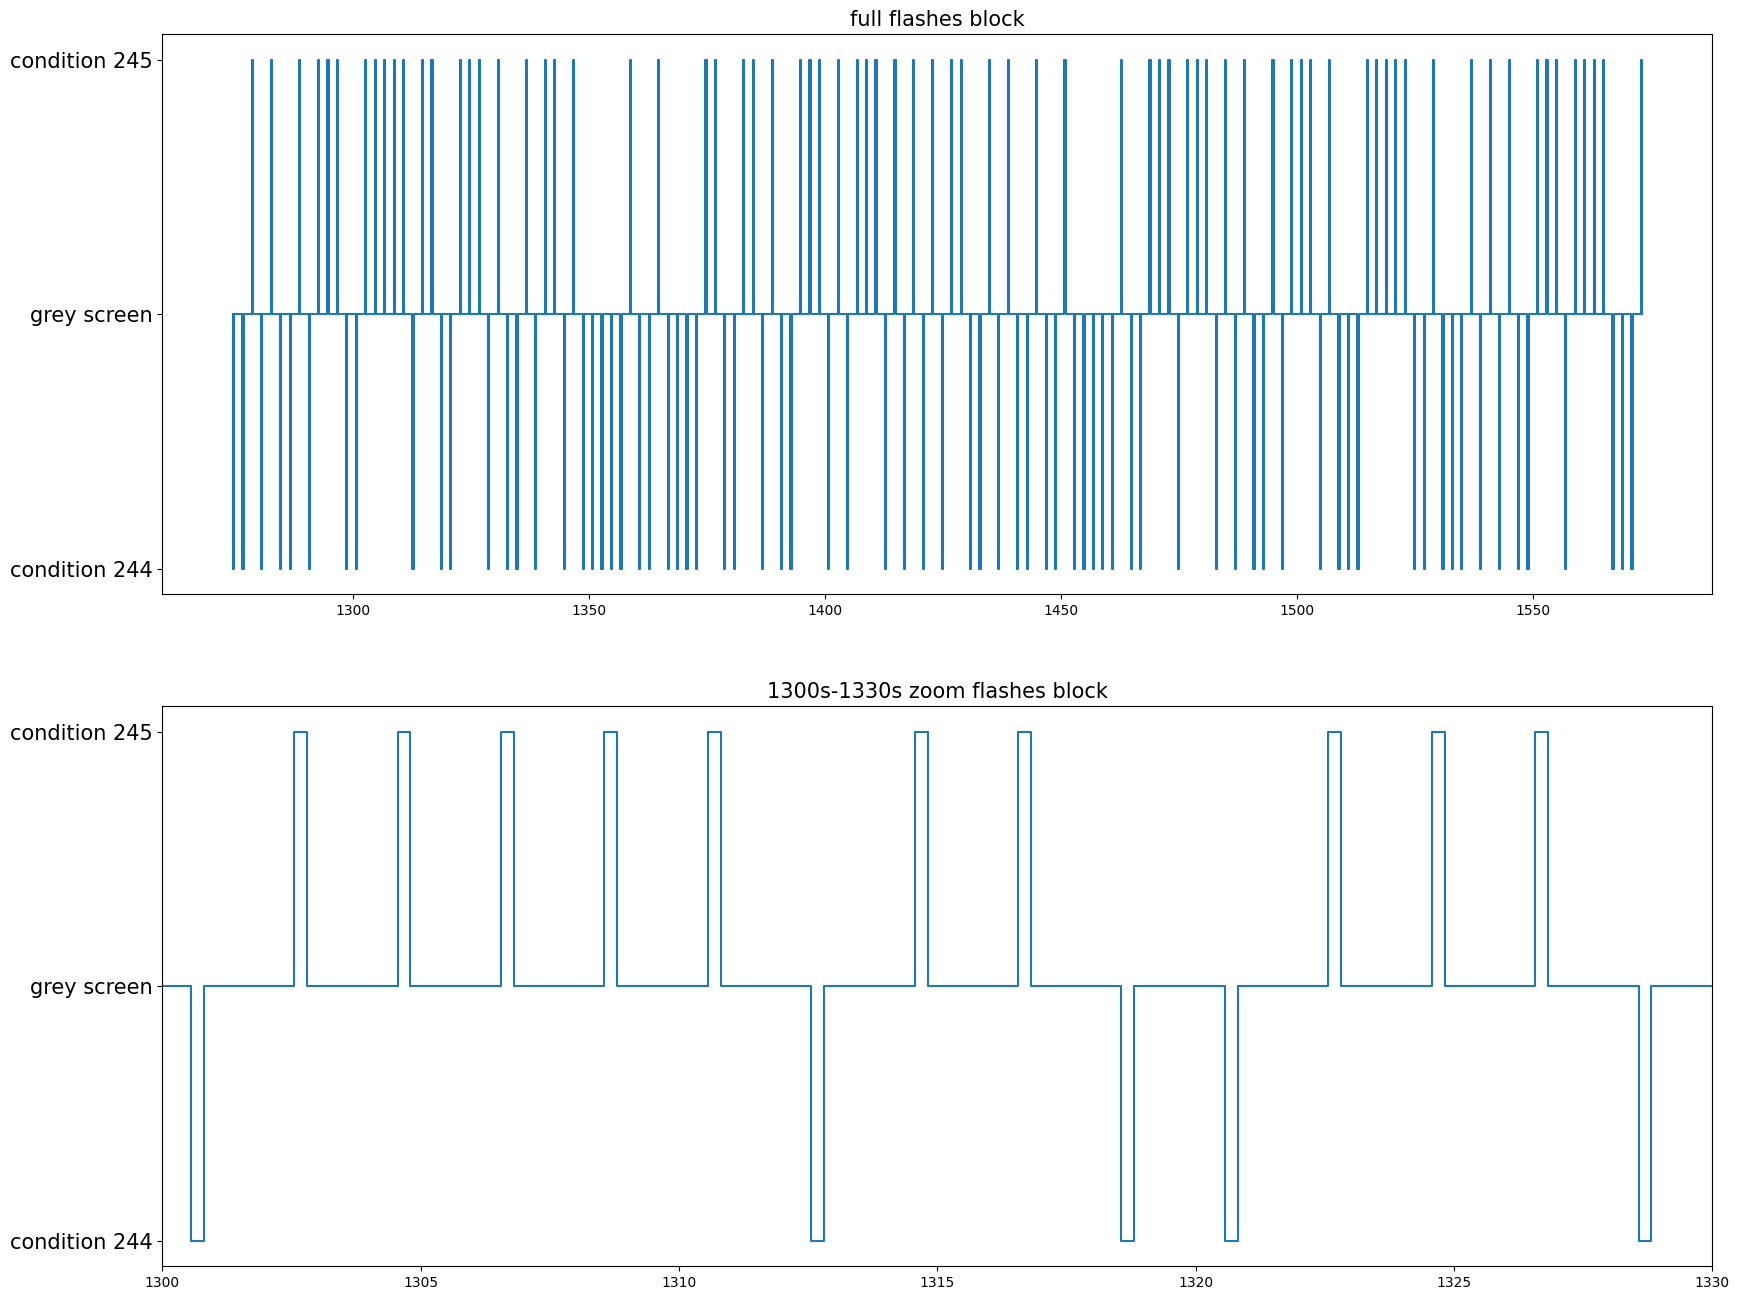

In [42]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,16))

ax[0].set_title('full flashes block',fontsize=15)
ax[0].set_yticks([-1,0,1])
ax[0].set_yticklabels(['condition 244','grey screen','condition 245'],fontsize=15)
ax[0].plot(plot_format_flash_times[:,0],plot_format_flash_times[:,1])

ax[1].set_title('1300s-1330s zoom flashes block',fontsize=15)
ax[1].set_yticks([-1,0,1])
ax[1].set_yticklabels(['condition 244','grey screen','condition 245'],fontsize=15)
ax[1].plot(plot_format_flash_times[:,0],plot_format_flash_times[:,1])
ax[1].set_xlim([1300,1330])

plt.show()

Flash stimuli are not alternating. As described in Neuropixels Visual Coding White Paper:</br>
"The receptive field mapping stimulus was followed by a series of dark or light fullfield flashes, lasting 250 ms each and separated by a 2 second inter-trial interval."

### Spectrograms

In [43]:
lfp_slice = lfp.sel(time=slice(start_time,end_time)).sel(channel=slice(850261782, 850261822))
lfp_slice

<xarray.DataArray 'LFP' (time: 736553, channel: 6)>
array([[-2.08649999e-05, -4.64100012e-05, -3.00299998e-05,
        -3.54900003e-05, -7.03949991e-05, -6.96150018e-05],
       [-2.45699994e-05, -4.91399987e-05, -3.72450013e-05,
        -4.11449982e-05, -7.27349980e-05, -7.97550019e-05],
       [-3.66599998e-05, -4.73850014e-05, -3.27599992e-05,
        -4.25100006e-05, -5.88900002e-05, -8.40450011e-05],
       ...,
       [-5.88900002e-05, -2.57400006e-05, -1.13099995e-05,
        -3.41249979e-05,  9.75000034e-07, -2.57400006e-05],
       [-8.11200007e-05, -3.06149996e-05, -1.01400001e-05,
        -4.01699981e-05,  1.05299996e-05, -3.52950010e-05],
       [-6.29849965e-05, -4.38749994e-05, -2.35949992e-05,
        -4.28999992e-05,  1.52100001e-05, -1.75499990e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 985.5 985.5 985.5 ... 1.575e+03 1.575e+03 1.575e+03
  * channel  (channel) int64 850261782 850261790 ... 850261814 850261822

In [44]:
ch = 850261806

In [45]:
# data = lfp_slice.sel(channel=ch).data
data = lfp_slice.mean(dim='channel').data
data.shape

(736553,)

In [46]:
print(f'LFP for channel {ch} was sampled at {layer5_channels_df[layer5_channels_df.index==ch].lfp_sampling_rate.item()} Hz')

LFP for channel 850261806 was sampled at 1249.999394567375 Hz


In [47]:
from matplotlib.patches import Rectangle


In [48]:
stim_flashes.head()

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1274.523973,1.0,flashes,1274.774189,0.250216,244
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1276.525623,1.0,flashes,1276.775842,0.250219,244
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1278.527343,1.0,flashes,1278.777552,0.250209,245
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1280.529013,1.0,flashes,1280.779222,0.250209,244
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1282.530723,1.0,flashes,1282.780924,0.250201,245


In [49]:
# help(Rectangle)

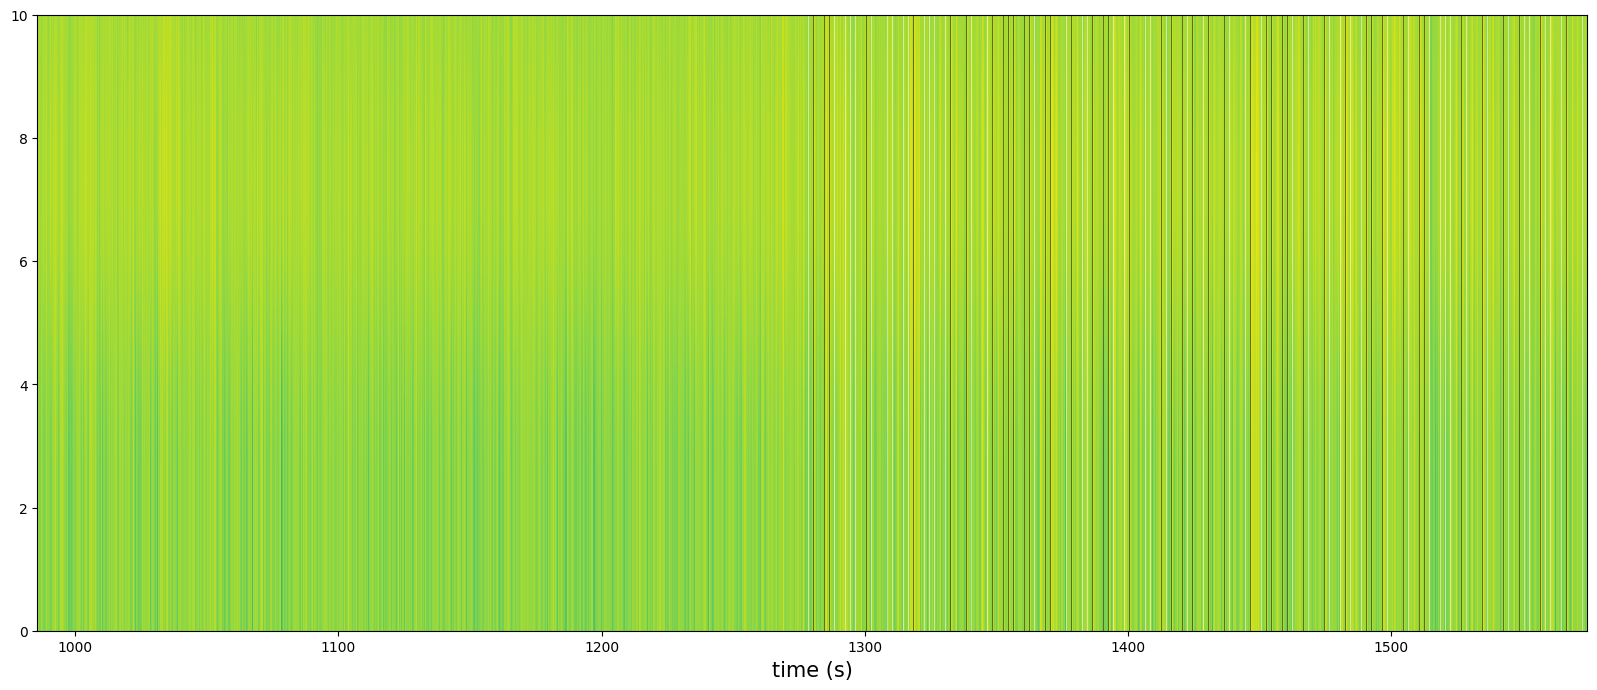

In [50]:
fig,ax = plt.subplots(figsize=(20,8))

powerSpectrum, freqenciesFound, time, imageAxis = ax.specgram(data,Fs=1250,xextent=(start_time,end_time))

# ax.axvline(x=stim_flashes.iloc[0].start_time,c='r')
# ax.axvline(x=stim_flashes.iloc[-1].stop_time,c='r')

col = {244:'black',245:'white'}
for stim in stim_flashes.iterrows():
    stim = stim[1]
    ax.add_patch(Rectangle((stim.start_time,0),stim.duration,freqenciesFound.max(),facecolor=col[stim.stimulus_condition_id],alpha=0.5))

ax.set_xlabel("time (s)", fontsize=15)
    
# ax.set_xlim([1300,1400])
ax.set_ylim([0,10])

plt.show()

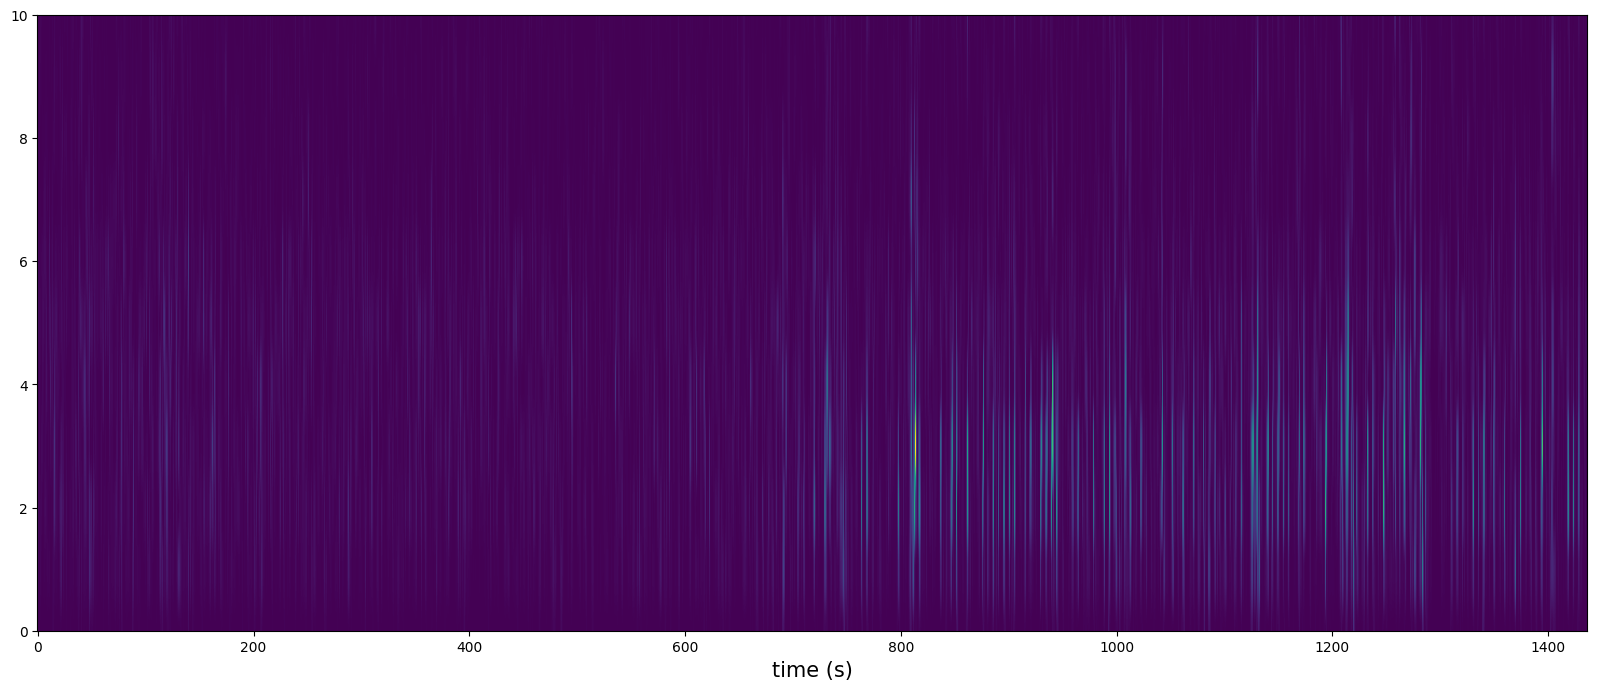

In [51]:
fig,ax = plt.subplots(figsize=(20,8))

frequencies, time, spectrogram = signal.spectrogram(data,fs=1250, nperseg=1024, noverlap=512, window='hann')

# ax.axvline(x=stim_flashes.iloc[0].start_time,c='r')
# ax.axvline(x=stim_flashes.iloc[-1].stop_time,c='r')

# col = {244:'black',245:'white'}
# for stim in stim_flashes.iterrows():
#     stim = stim[1]
#     ax.add_patch(Rectangle((stim.start_time,0),stim.duration,freqenciesFound.max(),facecolor=col[stim.stimulus_condition_id],alpha=1))

ax.set_xlabel("time (s)", fontsize=15)
    
# ax.set_xlim([1300,1400])
ax.set_ylim([0,10])

plt.imshow(spectrogram,aspect='auto',origin='lower')

plt.show()

<b>Wavelet Transform</b>

In [52]:
# https://elephant.readthedocs.io/en/latest/reference/_toctree/signal_processing/elephant.signal_processing.wavelet_transform.html
from elephant.signal_processing import wavelet_transform

In [53]:
freq_list = np.arange(1,10,9/50)
print(freq_list)
wt_data = wavelet_transform(data, frequency=freq_list, sampling_frequency=1250)

[1.   1.18 1.36 1.54 1.72 1.9  2.08 2.26 2.44 2.62 2.8  2.98 3.16 3.34
 3.52 3.7  3.88 4.06 4.24 4.42 4.6  4.78 4.96 5.14 5.32 5.5  5.68 5.86
 6.04 6.22 6.4  6.58 6.76 6.94 7.12 7.3  7.48 7.66 7.84 8.02 8.2  8.38
 8.56 8.74 8.92 9.1  9.28 9.46 9.64 9.82]


In [54]:
x_ticks_list = lfp_slice.mean(dim='channel').time.data
x_ticks_list

array([ 985.53261775,  985.53341775,  985.53421775, ..., 1574.77295711,
       1574.77375711, 1574.77455712])

In [93]:
wt_data.shape

(50, 736553)

In [96]:
freq_list.shape

(50,)

In [100]:
np.linspace(1,50,num=10)

array([ 1.        ,  6.44444444, 11.88888889, 17.33333333, 22.77777778,
       28.22222222, 33.66666667, 39.11111111, 44.55555556, 50.        ])

In [102]:
np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


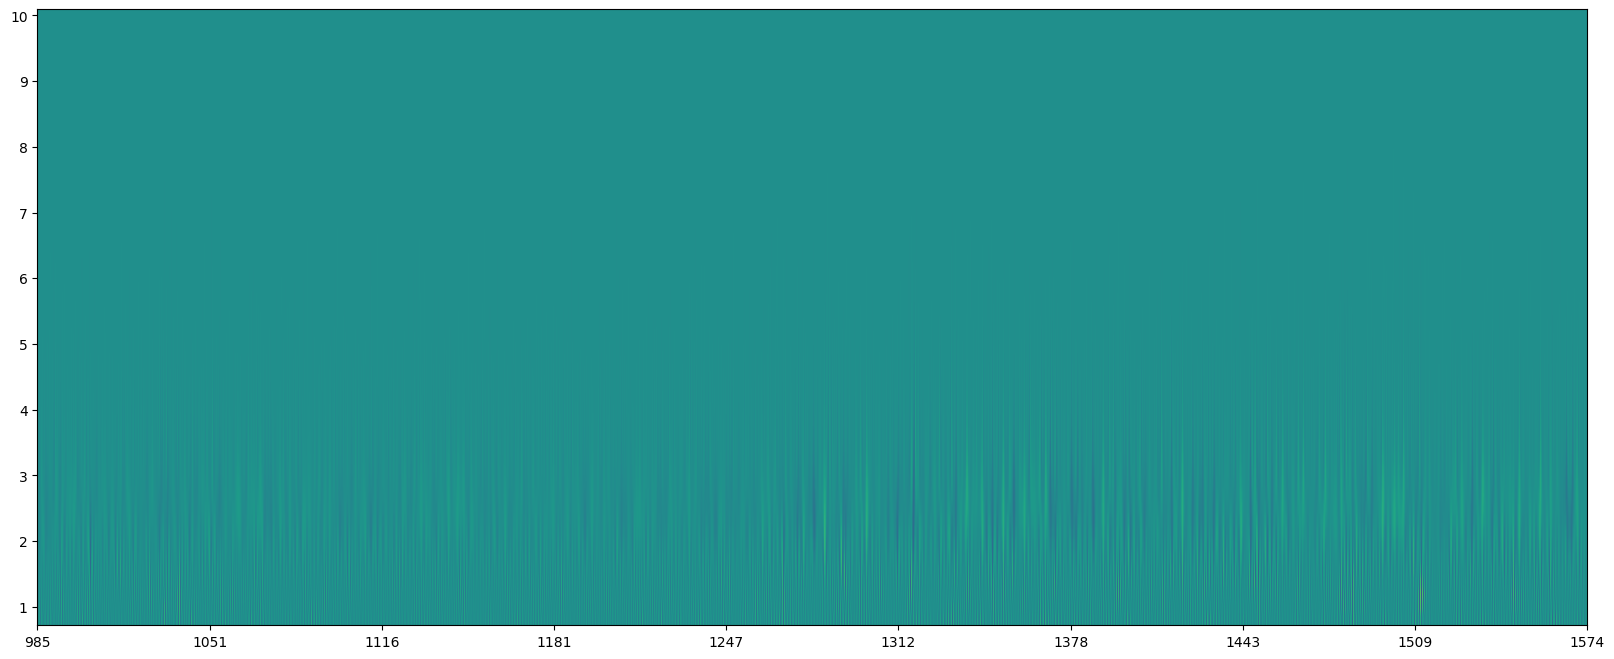

In [106]:
fig,ax = plt.subplots(figsize=(20,8))
ax.imshow(wt_data.astype(float)[:,:],aspect='auto',origin='lower')

ax.set_xticks(np.linspace(0,wt_data.shape[1],num=10))
ax.set_xticklabels(np.linspace(x_ticks_list[0],x_ticks_list[-1], num=10).astype(int))

# ax.set_yticks(np.linspace(0,wt_data.shape[0],num=5))
# ax.set_yticklabels(np.linspace(freq_list[0],freq_list[-1], num=5))
# ax.set_yticks(np.arange(0,freq_list.shape[0]))
# ax.set_yticklabels(np.linspace(freq_list[0],freq_list[-1], num=10))
ax.set_yticks(np.linspace(1,49,num=10))
ax.set_yticklabels(np.arange(1,11))

# plt.xticks(np.arange(0,100,step=5))
# plt.xtick_labels(x_ticks_list[:100])
plt.show()

In [90]:
ax.get_xticklabels()

[Text(-100000.0, 0, '−100000'),
 Text(0.0, 0, '0'),
 Text(100000.0, 0, '100000'),
 Text(200000.0, 0, '200000'),
 Text(300000.0, 0, '300000'),
 Text(400000.0, 0, '400000'),
 Text(500000.0, 0, '500000'),
 Text(600000.0, 0, '600000'),
 Text(700000.0, 0, '700000'),
 Text(800000.0, 0, '800000')]